In [1]:
import os
import shutil
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch.nn.functional as F
from tqdm import tqdm

import xml.etree.ElementTree as ET
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# 원본 데이터 경로 (압축 해제 후 폴더)
images_dir = './data/Images'  # 이미지들이 위치한 폴더
mat_dir = './data/lists'   # 프로젝트 루트 디렉토리

# .mat 파일 경로 (train_list.mat와 test_list.mat가 각각 같은 구조라고 가정)
train_mat_path = os.path.join(mat_dir, 'train_list.mat')
test_mat_path = os.path.join(mat_dir, 'test_list.mat')

# .mat 파일 로드
train_mat = sio.loadmat(train_mat_path)
test_mat = sio.loadmat(test_mat_path)

# train_mat와 test_mat 내부에 'file_list'와 'labels' 등이 있음
train_file_list = train_mat['file_list']
train_labels = train_mat['labels'].squeeze()  # (N,)
test_file_list = test_mat['file_list']
test_labels = test_mat['labels'].squeeze()

# 최종적으로 ImageFolder 구조로 재구성할 대상 폴더 생성 (예: stanford_dogs/train, stanford_dogs/test)
base_dir = 'stanford_dogs'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def process_mat_file(file_list_array, split_dir):
    """
    .mat 파일에서 로드한 file_list_array를 사용해,
    split_dir(예: train 혹은 test)에 클래스별 폴더를 생성하고 이미지를 복사합니다.
    """
    num_files = file_list_array.shape[0]
    for idx in range(num_files):
        # file_list_array[idx]는 보통 array([<파일경로>]) 형태입니다.
        # 따라서, array([<파일경로>]).item()을 사용하면 실제 문자열을 얻을 수 있습니다.
        file_path = file_list_array[idx][0].item()

        # 혹시 bytes 타입이면 문자열로 디코딩
        if isinstance(file_path, bytes):
            file_path = file_path.decode('utf-8')

        # 파일 경로 예시: 'n02116738-African_hunting_dog/n02116738_2988.jpg'
        # 클래스 이름은 파일 경로의 최상위 폴더명 (예: 'n02116738-African_hunting_dog')
        class_folder = file_path.split('/')[0]

        # 대상 클래스 폴더 생성
        dest_folder = os.path.join(split_dir, class_folder)
        os.makedirs(dest_folder, exist_ok=True)

        # 원본 이미지 경로: Images 폴더 아래에 file_path 위치
        src_path = os.path.join(images_dir, file_path)
        # 대상 이미지 경로: dest_folder 아래에 원본 파일명 그대로 복사
        dest_path = os.path.join(dest_folder, os.path.basename(file_path))

        # 파일 존재 여부 확인 후 복사
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
        else:
            print(f"File not found: {src_path}")

print("Processing train set...")
process_mat_file(train_file_list, train_dir)
print("Processing test set...")
process_mat_file(test_file_list, test_dir)

print("Dataset reorganization complete.")

Processing train set...
Processing test set...
Dataset reorganization complete.


In [3]:
class StanfordDogsDatasetWithBBox(datasets.ImageFolder):
    def __init__(self, root, annotation_root, transform=None):
        super().__init__(root, transform=transform)
        self.annotation_root = annotation_root  # 예: '/content/Annotation'
        self.new_size = (224, 224)

    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        path, _ = self.samples[index]
        
        rel_path = os.path.relpath(path, self.root)
        annot_filename = os.path.splitext(os.path.basename(rel_path))[0]
        annot_folder = os.path.dirname(rel_path)
        annot_path = os.path.join(self.annotation_root, annot_folder, annot_filename)

        # bbox 기본값 (예: [ymin, xmin, ymax, xmax])
        bbox = [0.0, 0.0, 0.0, 0.0]

        if os.path.exists(annot_path):
            try:
                # 확장자가 없지만 XML 형식의 파일이라고 가정하고 파싱
                tree = ET.parse(annot_path)
                root_xml = tree.getroot()
                # 첫 번째 object 태그에서 bndbox 정보를 읽음
                obj = root_xml.find('object')
                if obj is not None:
                    bndbox = obj.find('bndbox')
                    if bndbox is not None:
                        xmin = float(bndbox.find('xmin').text)
                        ymin = float(bndbox.find('ymin').text)
                        xmax = float(bndbox.find('xmax').text)
                        ymax = float(bndbox.find('ymax').text)
                        # XML 내 <size> 태그에서 원본 이미지 크기 획득
                        size = root_xml.find('size')
                        w = float(size.find('width').text)
                        h = float(size.find('height').text)
                        new_h, new_w = self.new_size
                        # bbox 좌표 순서: [ymin, xmin, ymax, xmax]
                        bbox = [xmin * (new_w / w), ymin * (new_h / h),
                                xmax * (new_w / w), ymax * (new_h / h)]
                    else:
                        print(f"bndbox 태그를 찾을 수 없습니다: {annot_path}")
                else:
                    print(f"object 태그를 찾을 수 없습니다: {annot_path}")
            except Exception as e:
                print(f"Error parsing {annot_path}: {e}")
        else:
            print(f"Annotation file not found: {annot_path}")

        return image, label, bbox

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 데이터셋 경로 (재구성한 ImageFolder 형식)
train_dir = os.path.join('stanford_dogs', 'train')
test_dir = os.path.join('stanford_dogs', 'test')
# Annotation 폴더 경로 (예: '/root/Annotation')
annotation_dir = './data/Annotation'

# 커스텀 데이터셋 생성: image, label, bbox 반환
train_dataset = StanfordDogsDatasetWithBBox(root=train_dir, annotation_root=annotation_dir, transform=transform)
valid_dataset = StanfordDogsDatasetWithBBox(root=test_dir, annotation_root=annotation_dir, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(valid_dataset)}")

Number of classes: 120
Train samples: 12000
Test samples: 8580


In [5]:
def visualize(sample):
    img_tensor, label, bbox = sample

    # 인덱스와 클래스 정보
    print("Label index:", label)
    print("Class name:", train_dataset.classes[label])

    # 정규화 복원 전처리 시 사용한 평균과 표준편차
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # tensor의 shape: (C, H, W) -> (H, W, C)
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    plt.figure(figsize=(6,6))
    plt.imshow(img_np)
    plt.title(f"Class: {train_dataset.classes[label]}")
    plt.axis('off')
    plt.show()

Label index: 0
Class name: n02085620-Chihuahua


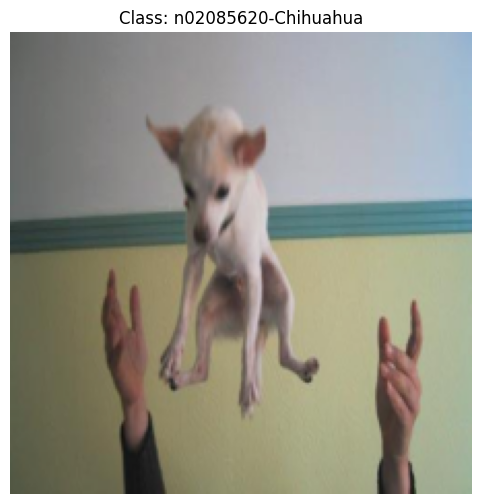

In [6]:
# 임의의 한 샘플 선택 (여기서는 첫 번째 샘플을 사용)
train_sample = train_dataset[0]

visualize(train_sample)

In [7]:
# Annotation 폴더에서 데이터를 골라보세요
annotation_path = './data/Annotation/n02085620-Chihuahua/n02085620_10074'


# XML 파일 파싱
tree = ET.parse(annotation_path)
root = tree.getroot()

for elem in root.iter():
    print(f"{elem.tag}: {elem.text}")

annotation: 
	
folder: 02085620
filename: n02085620_10074
source: 
		
database: ImageNet database
size: 
		
width: 333
height: 500
depth: 3
segment: 0
object: 
		
name: Chihuahua
pose: Unspecified
truncated: 0
difficult: 0
bndbox: 
			
xmin: 25
ymin: 10
xmax: 276
ymax: 498


In [8]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)
model

c:\Users\tkdwl\miniconda3\envs\aiffel\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tkdwl\miniconda3\envs\aiffel\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:

def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=2):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        len_loader = len(train_loader)

        # ★ tqdm에 total 명시 + enumerate
        for batch_idx, (images, labels, _) in tqdm(enumerate(train_loader)):
            # ★ 여기서 print 대신 tqdm.write 사용
            tqdm.write(f"{batch_idx}/{len_loader} progress")
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            if (batch_idx + 1) % 50 == 0:
                tqdm.write(f"  Step {batch_idx+1} - Loss: {loss.item():.4f}")

        train_loss = running_loss / (batch_idx + 1)
        train_acc = correct / total
        print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_acc*100:.2f}%")

        # --------- Validation ---------
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, _ in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        test_loss = running_loss / len(valid_loader)
        test_acc = correct / total
        print(f"Validation - Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")

In [11]:
train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=2)


Epoch 1/2 시작
cuda


0it [00:01, ?it/s]

0/94 progress


1it [00:03,  2.29s/it]

1/94 progress


2it [00:05,  1.92s/it]

2/94 progress


3it [00:07,  1.84s/it]

3/94 progress


4it [00:08,  1.81s/it]

4/94 progress


5it [00:10,  1.78s/it]

5/94 progress


6it [00:12,  1.77s/it]

6/94 progress


7it [00:14,  1.77s/it]

7/94 progress


8it [00:15,  1.76s/it]

8/94 progress


9it [00:17,  1.75s/it]

9/94 progress


10it [00:19,  1.74s/it]

10/94 progress


11it [00:21,  1.74s/it]

11/94 progress


12it [00:22,  1.73s/it]

12/94 progress


13it [00:24,  1.73s/it]

13/94 progress


14it [00:26,  1.74s/it]

14/94 progress


15it [00:27,  1.73s/it]

15/94 progress


16it [00:29,  1.74s/it]

16/94 progress


17it [00:31,  1.71s/it]

17/94 progress


18it [00:33,  1.71s/it]

18/94 progress


19it [00:34,  1.72s/it]

19/94 progress


20it [00:36,  1.72s/it]

20/94 progress


21it [00:38,  1.75s/it]

21/94 progress


22it [00:40,  1.76s/it]

22/94 progress


23it [00:41,  1.77s/it]

23/94 progress


24it [00:43,  1.78s/it]

24/94 progress


25it [00:45,  1.78s/it]

25/94 progress


26it [00:47,  1.79s/it]

26/94 progress


27it [00:49,  1.80s/it]

27/94 progress


28it [00:51,  1.80s/it]

28/94 progress


29it [00:52,  1.80s/it]

29/94 progress


30it [00:54,  1.80s/it]

30/94 progress


31it [00:56,  1.80s/it]

31/94 progress


32it [00:58,  1.79s/it]

32/94 progress


33it [01:00,  1.79s/it]

33/94 progress


34it [01:01,  1.81s/it]

34/94 progress


35it [01:03,  1.80s/it]

35/94 progress


36it [01:05,  1.80s/it]

36/94 progress


37it [01:07,  1.80s/it]

37/94 progress


38it [01:08,  1.78s/it]

38/94 progress


39it [01:10,  1.80s/it]

39/94 progress


40it [01:12,  1.82s/it]

40/94 progress


41it [01:14,  1.81s/it]

41/94 progress


42it [01:16,  1.82s/it]

42/94 progress


43it [01:18,  1.82s/it]

43/94 progress


44it [01:19,  1.81s/it]

44/94 progress


45it [01:21,  1.80s/it]

45/94 progress


46it [01:23,  1.81s/it]

46/94 progress


47it [01:25,  1.82s/it]

47/94 progress


48it [01:27,  1.82s/it]

48/94 progress


49it [01:29,  1.82s/it]

49/94 progress


50it [01:29,  1.82s/it]

  Step 50 - Loss: 1.2442


50it [01:30,  1.82s/it]

50/94 progress


51it [01:32,  1.84s/it]

51/94 progress


52it [01:34,  1.82s/it]

52/94 progress


53it [01:36,  1.79s/it]

53/94 progress


54it [01:38,  1.82s/it]

54/94 progress


55it [01:39,  1.79s/it]

55/94 progress


56it [01:41,  1.85s/it]

56/94 progress


57it [01:43,  1.89s/it]

57/94 progress


58it [01:45,  1.94s/it]

58/94 progress


59it [01:47,  1.87s/it]

59/94 progress


60it [01:48,  1.80s/it]

60/94 progress


61it [01:50,  1.74s/it]

61/94 progress


62it [01:52,  1.73s/it]

62/94 progress


63it [01:54,  1.78s/it]

63/94 progress


64it [01:56,  1.86s/it]

64/94 progress


65it [01:58,  1.89s/it]

65/94 progress


66it [02:00,  1.81s/it]

66/94 progress


67it [02:01,  1.82s/it]

67/94 progress


68it [02:03,  1.80s/it]

68/94 progress


69it [02:05,  1.80s/it]

69/94 progress


70it [02:07,  1.78s/it]

70/94 progress


71it [02:08,  1.78s/it]

71/94 progress


72it [02:10,  1.81s/it]

72/94 progress


73it [02:12,  1.78s/it]

73/94 progress


74it [02:14,  1.79s/it]

74/94 progress


75it [02:16,  1.80s/it]

75/94 progress


76it [02:17,  1.78s/it]

76/94 progress


77it [02:19,  1.77s/it]

77/94 progress


78it [02:21,  1.78s/it]

78/94 progress


79it [02:23,  1.77s/it]

79/94 progress


80it [02:24,  1.76s/it]

80/94 progress


81it [02:26,  1.76s/it]

81/94 progress


82it [02:28,  1.77s/it]

82/94 progress


83it [02:30,  1.75s/it]

83/94 progress


84it [02:31,  1.74s/it]

84/94 progress


85it [02:33,  1.72s/it]

85/94 progress


86it [02:35,  1.73s/it]

86/94 progress


87it [02:37,  1.75s/it]

87/94 progress


88it [02:38,  1.78s/it]

88/94 progress


89it [02:40,  1.78s/it]

89/94 progress


90it [02:42,  1.76s/it]

90/94 progress


91it [02:44,  1.75s/it]

91/94 progress


92it [02:45,  1.76s/it]

92/94 progress


93it [02:47,  1.74s/it]

93/94 progress


94it [02:47,  1.78s/it]


Train - Loss: 1.9974, Accuracy: 57.59%
Validation - Loss: 0.8616, Accuracy: 74.93%

Epoch 2/2 시작
cuda


0it [00:00, ?it/s]

0/94 progress


1it [00:00,  1.50it/s]

1/94 progress


2it [00:01,  1.54it/s]

2/94 progress


3it [00:02,  1.56it/s]

3/94 progress


4it [00:02,  1.58it/s]

4/94 progress


5it [00:03,  1.58it/s]

5/94 progress


6it [00:04,  1.60it/s]

6/94 progress


7it [00:04,  1.60it/s]

7/94 progress


8it [00:05,  1.61it/s]

8/94 progress


9it [00:05,  1.62it/s]

9/94 progress


10it [00:06,  1.61it/s]

10/94 progress


11it [00:07,  1.60it/s]

11/94 progress


12it [00:07,  1.62it/s]

12/94 progress


13it [00:08,  1.59it/s]

13/94 progress


14it [00:09,  1.61it/s]

14/94 progress


15it [00:09,  1.60it/s]

15/94 progress


16it [00:10,  1.60it/s]

16/94 progress


17it [00:10,  1.60it/s]

17/94 progress


18it [00:11,  1.60it/s]

18/94 progress


19it [00:12,  1.60it/s]

19/94 progress


20it [00:12,  1.61it/s]

20/94 progress


21it [00:13,  1.61it/s]

21/94 progress


22it [00:14,  1.61it/s]

22/94 progress


23it [00:14,  1.61it/s]

23/94 progress


24it [00:15,  1.61it/s]

24/94 progress


25it [00:15,  1.62it/s]

25/94 progress


26it [00:16,  1.62it/s]

26/94 progress


27it [00:17,  1.60it/s]

27/94 progress


28it [00:17,  1.60it/s]

28/94 progress


29it [00:18,  1.57it/s]

29/94 progress


30it [00:19,  1.57it/s]

30/94 progress


31it [00:19,  1.59it/s]

31/94 progress


32it [00:20,  1.59it/s]

32/94 progress


33it [00:20,  1.59it/s]

33/94 progress


34it [00:21,  1.59it/s]

34/94 progress


35it [00:22,  1.61it/s]

35/94 progress


36it [00:22,  1.61it/s]

36/94 progress


37it [00:23,  1.62it/s]

37/94 progress


38it [00:24,  1.62it/s]

38/94 progress


39it [00:24,  1.62it/s]

39/94 progress


40it [00:25,  1.62it/s]

40/94 progress


41it [00:25,  1.60it/s]

41/94 progress


42it [00:26,  1.58it/s]

42/94 progress


43it [00:27,  1.56it/s]

43/94 progress


44it [00:27,  1.57it/s]

44/94 progress


45it [00:28,  1.55it/s]

45/94 progress


46it [00:29,  1.55it/s]

46/94 progress


47it [00:29,  1.55it/s]

47/94 progress


48it [00:30,  1.57it/s]

48/94 progress


49it [00:31,  1.58it/s]

49/94 progress


50it [00:31,  1.58it/s]

  Step 50 - Loss: 0.4825


50it [00:31,  1.58it/s]

50/94 progress


51it [00:32,  1.58it/s]

51/94 progress


52it [00:32,  1.57it/s]

52/94 progress


53it [00:33,  1.58it/s]

53/94 progress


54it [00:34,  1.59it/s]

54/94 progress


55it [00:34,  1.57it/s]

55/94 progress


56it [00:35,  1.57it/s]

56/94 progress


57it [00:36,  1.56it/s]

57/94 progress


58it [00:36,  1.55it/s]

58/94 progress


59it [00:37,  1.54it/s]

59/94 progress


60it [00:38,  1.56it/s]

60/94 progress


61it [00:38,  1.56it/s]

61/94 progress


62it [00:39,  1.56it/s]

62/94 progress


63it [00:39,  1.59it/s]

63/94 progress


64it [00:40,  1.58it/s]

64/94 progress


65it [00:41,  1.55it/s]

65/94 progress


66it [00:41,  1.57it/s]

66/94 progress


67it [00:42,  1.59it/s]

67/94 progress


68it [00:43,  1.60it/s]

68/94 progress


69it [00:43,  1.60it/s]

69/94 progress


70it [00:44,  1.59it/s]

70/94 progress


71it [00:45,  1.60it/s]

71/94 progress


72it [00:45,  1.61it/s]

72/94 progress


73it [00:46,  1.59it/s]

73/94 progress


74it [00:46,  1.60it/s]

74/94 progress


75it [00:47,  1.58it/s]

75/94 progress


76it [00:48,  1.59it/s]

76/94 progress


77it [00:48,  1.60it/s]

77/94 progress


78it [00:49,  1.60it/s]

78/94 progress


79it [00:50,  1.60it/s]

79/94 progress


80it [00:50,  1.57it/s]

80/94 progress


81it [00:51,  1.58it/s]

81/94 progress


82it [00:51,  1.60it/s]

82/94 progress


83it [00:52,  1.57it/s]

83/94 progress


84it [00:53,  1.60it/s]

84/94 progress


85it [00:53,  1.59it/s]

85/94 progress


86it [00:54,  1.58it/s]

86/94 progress


87it [00:55,  1.57it/s]

87/94 progress


88it [00:55,  1.58it/s]

88/94 progress


89it [00:56,  1.58it/s]

89/94 progress


90it [00:56,  1.59it/s]

90/94 progress


91it [00:57,  1.59it/s]

91/94 progress


92it [00:58,  1.59it/s]

92/94 progress


93it [00:58,  1.58it/s]

93/94 progress


94it [00:59,  1.59it/s]


Train - Loss: 0.5145, Accuracy: 85.57%
Validation - Loss: 0.7800, Accuracy: 75.66%


In [12]:
# Q. '/work/class_activation_map' 에 'cam_model1.h5'을 저장하세요.

cam_model_path = "./data/cam_model.pt"

torch.save(model, cam_model_path)

In [13]:
def unnormalize(img_tensor):
    """
    img_tensor: [C, H, W] 텐서 (전처리 상태, 예: normalization 적용됨)
    ImageNet 평균 및 표준편차를 이용하여 복원 (RGB 순서)
    """
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    img = np.uint8(255 * img)
    return img

In [14]:
image, label, bbox = train_dataset[0]
sample_image = image.unsqueeze(0).to(device)
model = torch.load(cam_model_path, weights_only=False)

In [15]:
def generate_cam(model, image):
    model.eval()
    features = []

    def hook(module, input, output):
        features.append(output.detach())
    hook_handle = model.layer4.register_forward_hook(hook)

    output = model(image)
    hook_handle.remove()

    # 예측된 클래스 선택 (배치의 첫 번째 이미지 기준)
    pred_class = output.argmax(dim=1).item()

    # 모델의 fc layer 가중치가 모델과 동일한 디바이스에 있도록 처리
    fc_weights = model.fc.weight.data.to(image.device)

    # features[0]: shape [1, num_features, H, W]
    fmap = features[0][0]  # 첫 번째 이미지의 feature map
    cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=image.device)

    # fc 가중치와 feature map의 각 채널을 가중합
    for i, w in enumerate(fc_weights[pred_class]):
        cam += w * fmap[i, :, :]
    cam = cam.cpu().numpy()

    # CAM 정규화
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam) + 1e-8)

    return cam

In [16]:
cam = generate_cam(model, sample_image)

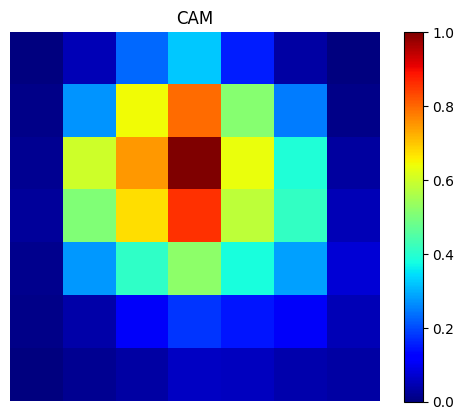

In [17]:
def visualize_cam(cam):
    plt.imshow(cam, cmap='jet')
    plt.colorbar()
    plt.title("CAM")
    plt.axis('off')
    plt.show()

visualize_cam(cam)

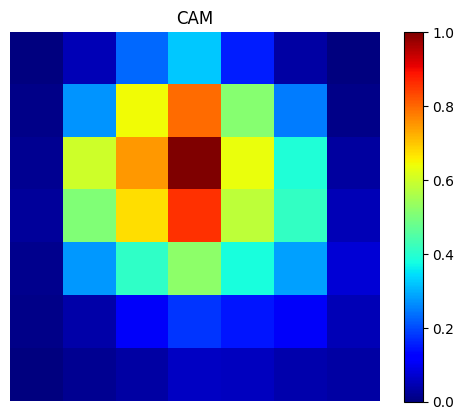

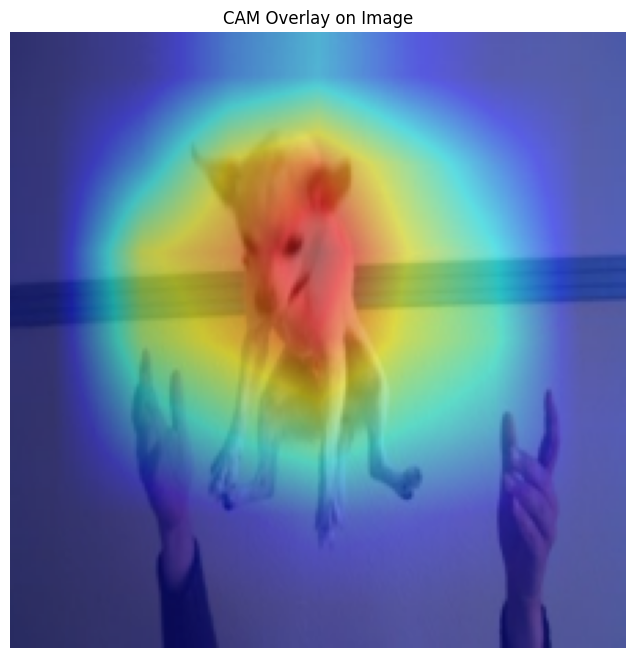

In [18]:
def visualize_cam_on_image(cam, img, alpha=0.5):
    # CAM 크기를 원본 이미지 크기로 조정
    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

    # CAM을 컬러 heatmap으로 변환 (cv2.applyColorMap는 BGR로 반환하므로 RGB로 변경)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # 원본 이미지와 heatmap을 alpha blending
    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = overlay.astype(np.uint8)

    plt.figure(figsize=(8,8))
    plt.imshow(overlay)
    plt.title("CAM Overlay on Image")
    plt.axis('off')
    plt.show()

# 원본 이미지 복원
orig_img = unnormalize(image)

# CAM 단독 시각화
visualize_cam(cam)

# 원본 이미지 위에 CAM overlay 시각화
visualize_cam_on_image(cam, orig_img)

In [19]:
def generate_grad_cam(model, image, target_layer_name):
    model.eval()
    features = {}
    gradients = {}

    # forward hook: 대상 레이어의 출력을 저장
    def forward_hook(module, input, output):
        features['value'] = output.detach()

    # backward hook: 대상 레이어의 gradient를 저장
    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    # 모델 내에서 이름이 target_layer_name과 일치하는 레이어 검색
    target_layer = dict(model.named_modules()).get(target_layer_name, None)
    if target_layer is None:
        raise ValueError(f"Layer '{target_layer_name}' not found in the model.")

    # hook 등록
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # 순전파 실행
    output = model(image)
    pred_class = output.argmax(dim=1).item()

    # 예측 클래스에 대해 backward 수행
    model.zero_grad()
    score = output[0, pred_class]
    score.backward()

    # hook 제거
    forward_handle.remove()
    backward_handle.remove()

    # 저장된 feature map과 gradient 추출 (shape: [C, H, W])
    fmap = features['value'][0]
    grads = gradients['value'][0]

    # 각 채널에 대해 gradient의 global average pooling 계산 (weight 역할)
    weights = torch.mean(grads, dim=(1, 2))

    # weighted sum: 각 채널의 feature map에 weight를 곱해 합산
    grad_cam = torch.zeros(fmap.shape[1:], dtype=torch.float32, device=fmap.device)
    for i, w in enumerate(weights):
        grad_cam += w * fmap[i, :, :]
    grad_cam = grad_cam.cpu().numpy()

    # ReLU 적용 및 정규화: 음수 값 제거 및 [0,1] 범위로 스케일링
    grad_cam = np.maximum(grad_cam, 0)
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min() + 1e-8)

    return grad_cam

c:\Users\tkdwl\miniconda3\envs\aiffel\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


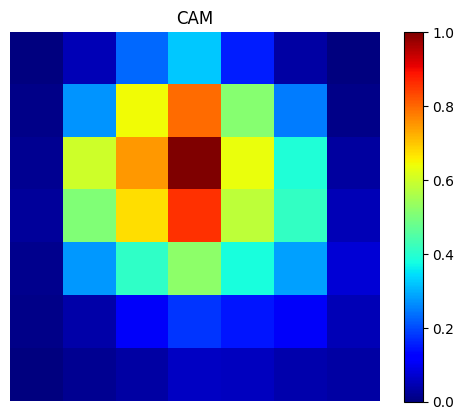

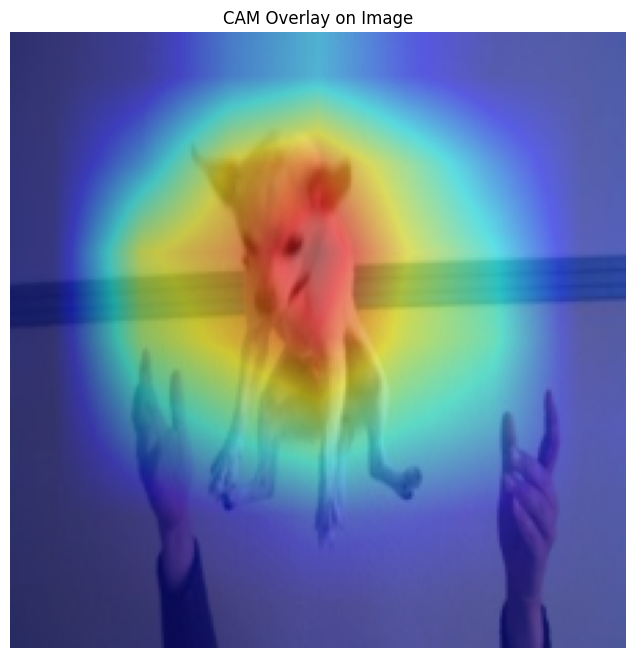

In [20]:
# layer4 사용
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer4")

# Grad-CAM 단독 시각화
visualize_cam(grad_cam)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)
visualize_cam_on_image(grad_cam, orig_img)

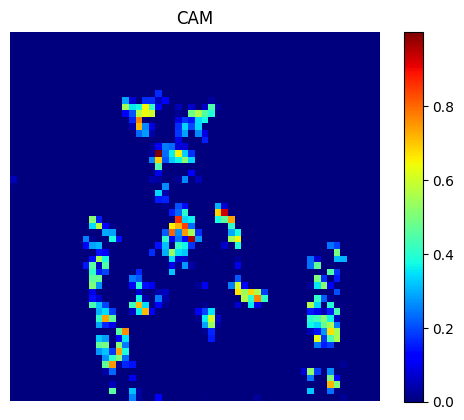

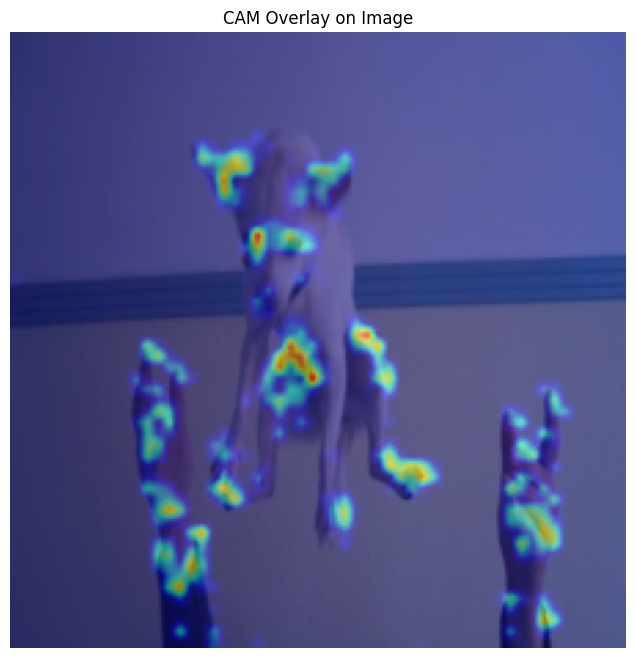

In [21]:
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer1")

# Grad-CAM 단독 시각화
visualize_cam(grad_cam)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)
visualize_cam_on_image(grad_cam, orig_img)

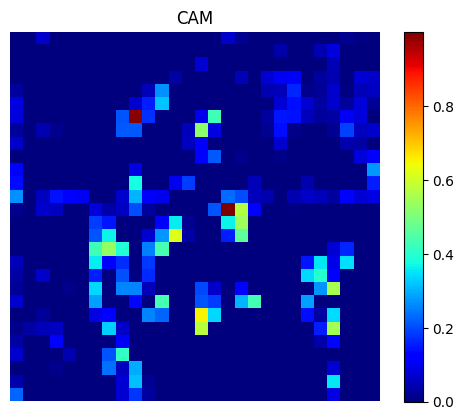

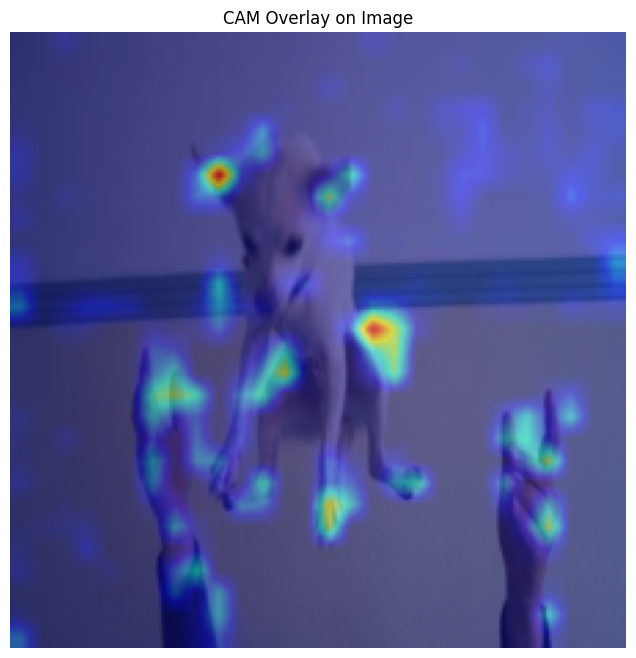

In [22]:
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer2")

# Grad-CAM 단독 시각화
visualize_cam(grad_cam)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)
visualize_cam_on_image(grad_cam, orig_img)

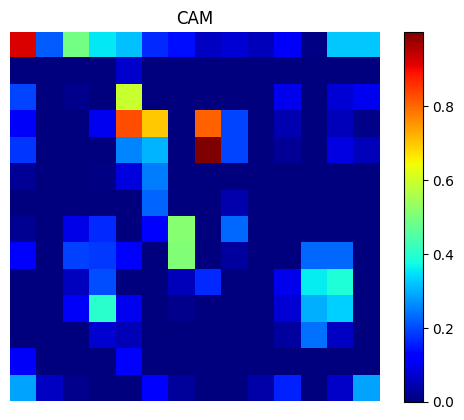

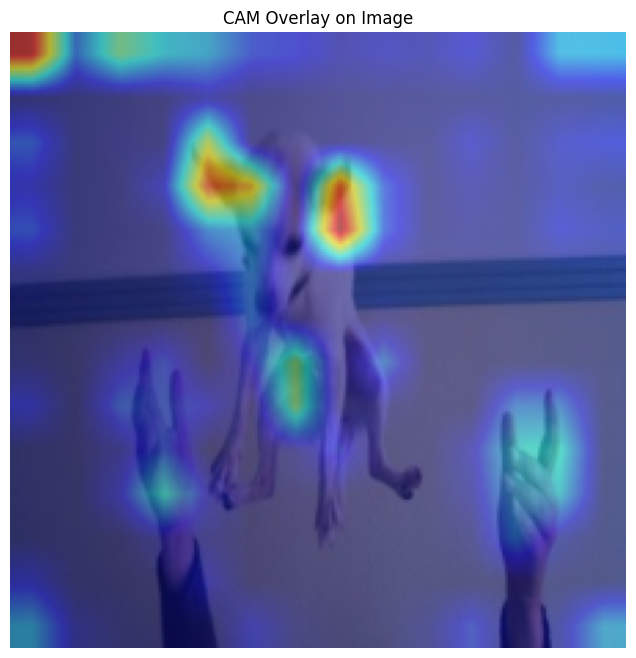

In [23]:
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer3")

# Grad-CAM 단독 시각화
visualize_cam(grad_cam)

# 전처리된 이미지를 원본 이미지로 복원 후 overlay 시각화
orig_img = unnormalize(image)
visualize_cam_on_image(grad_cam, orig_img)

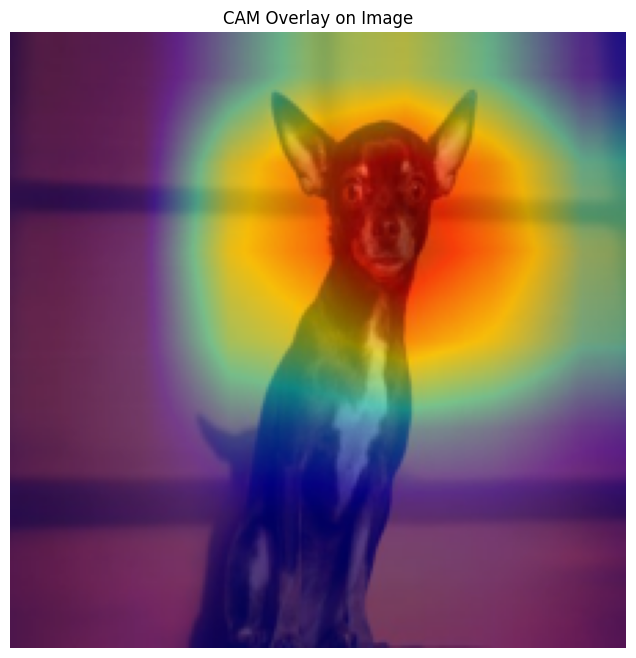

In [24]:
image, label, ground_bbox = train_dataset[10]
sample_image = image.unsqueeze(0).to(device)
orig_img = unnormalize(image)
grad_cam = generate_grad_cam(model, sample_image, target_layer_name="layer4")

visualize_cam_on_image(grad_cam, orig_img)

In [32]:
def get_bbox(cam, threshold=0.01):
    coords = np.argwhere(cam > threshold)
    if coords.size == 0:
        return None
    # np.argwhere의 결과는 (row, col) 즉, (y, x) 순서입니다.
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    return (x_min, y_min, x_max, y_max)

def visualize_bbox_on_image(img, bbox, box_color=(255, 0, 0), thickness=2):
    # 원본 이미지 복사
    img_with_bbox = img.copy()
    if bbox is not None:
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), box_color, thickness)
    else:
        print("활성화된 영역이 없습니다.")
    return img_with_bbox

def get_iou(bbox1, bbox2):
    # bbox 중 하나라도 None이면 IoU 0.0
    if bbox1 is None or bbox2 is None:
        return 0.0

    x_min1, y_min1, x_max1, y_max1 = bbox1
    x_min2, y_min2, x_max2, y_max2 = bbox2

    # 두 bbox의 교집합 영역 좌표 계산
    x_min_inter = max(x_min1, x_min2)
    y_min_inter = max(y_min1, y_min2)
    x_max_inter = min(x_max1, x_max2)
    y_max_inter = min(y_max1, y_max2)

    # 교집합의 너비와 높이 (음수가 되지 않도록)
    inter_width = max(0, x_max_inter - x_min_inter)
    inter_height = max(0, y_max_inter - y_min_inter)
    inter_area = inter_width * inter_height

    # 각 bbox의 면적 계산
    area1 = (x_max1 - x_min1) * (y_max1 - y_min1)
    area2 = (x_max2 - x_min2) * (y_max2 - y_min2)

    # 합집합 면적: A ∪ B = A + B - A ∩ B
    union_area = area1 + area2 - inter_area
    if union_area <= 0:
        return 0.0

    iou = inter_area / union_area
    return iou

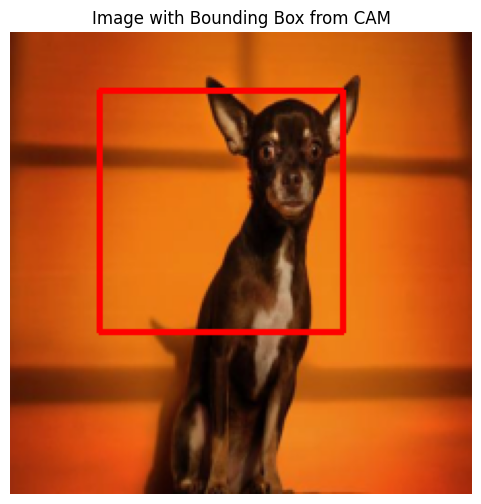

In [28]:
cam_resized = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))
bbox = get_bbox(cam_resized, threshold=0.5)

img_bbox = visualize_bbox_on_image(orig_img, bbox)

plt.figure(figsize=(6,6))
plt.imshow(img_bbox)
plt.title("Image with Bounding Box from CAM")
plt.axis("off")
plt.show()

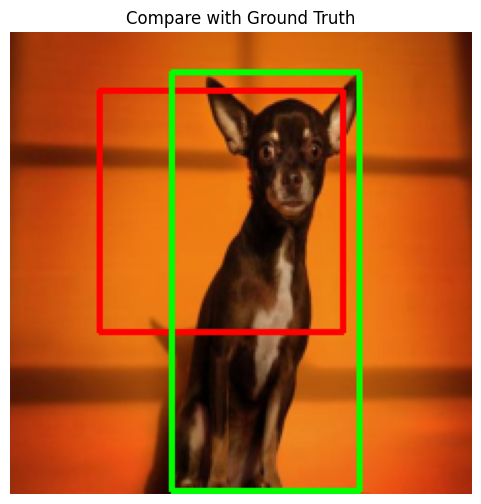

In [34]:
get_iou(bbox, ground_bbox)

def visualize_both_bbox_on_image(img, bbox, ground_truth, thickness=2):
    # 원본 이미지 복사
    img_with_bbox = img.copy()

    x_min, y_min, x_max, y_max = bbox
    cv2.rectangle(img_with_bbox, (x_min, y_min), (x_max, y_max), (255, 0, 0), thickness)

    x_min_t, y_min_t, x_max_t, y_max_t = ground_truth
    cv2.rectangle(img_with_bbox, (x_min_t, y_min_t), (x_max_t, y_max_t), (0, 255, 0), thickness)

    return img_with_bbox

ground_truth = [int(x) for x in ground_bbox]

img_bbox = visualize_both_bbox_on_image(orig_img, bbox, ground_truth)

plt.figure(figsize=(6,6))
plt.imshow(img_bbox)
plt.title("Compare with Ground Truth")
plt.axis("off")
plt.show()